In [1]:
#import libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
# Load datasets
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"

try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')

try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

# Concatenate datasets
df = pd.concat([df1, df2], ignore_index=True)
# Data Preprocessing
stop_words = set(stopwords.words('english'))

In [3]:
#data preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df['text'] = df['news'].apply(preprocess_text)
df['label'] = df['label'].apply(lambda x: x.lower())

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [4]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [5]:
# Word2Vec embeddings
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word2vec_model.wv), word2vec_model.vector_size))
for i in range(len(word2vec_model.wv)):
    embedding_vector = word2vec_model.wv[word2vec_model.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
# Define custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2vec_model):
        self.texts = texts
        self.labels = labels
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = text.split()
        vec = np.zeros(self.word2vec_model.vector_size)
        for token in tokens:
            if token in self.word2vec_model.wv:
                vec += self.word2vec_model.wv[token]
        return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TextDataset(X_train, y_train, word2vec_model)
test_dataset = TextDataset(X_test, y_test, word2vec_model)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define FeedForwardNN model architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation_function, dropout):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.dropout = nn.Dropout(dropout)
        self.activation_function = activation_function
        self.fc2 = nn.Linear(hidden_dims[-1], 3)  # 3 classes for sentiment analysis
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation_function(x)
            x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Model parameters
input_dim = embedding_matrix.shape[1]
hidden_dims = [500, 300] #2 hidden layers
dropout = 0.2 #dropout rate
activation_function = nn.ReLU() #activation function
lr = 0.0001 #learning rate

# Initialize model, loss function, and optimizer
model = FeedForwardNN(input_dim, hidden_dims, activation_function, dropout)
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(model.parameters(), lr=lr) #optimizer

In [8]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()# Set the model to training mode
    for i, (inputs, labels) in enumerate(train_loader):# Loop over each batch in the training data loader
        optimizer.zero_grad()
        outputs = model(inputs)# Forward pass: compute the model output
        loss = criterion(outputs, labels)# Compute the loss between the model outputs and the true labels
        loss.backward() #compute the gradients of the loss with respect to model parameters
        optimizer.step()# Update model parameters using the optimizer

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/15], Loss: 0.9033
Epoch [2/15], Loss: 0.9717
Epoch [3/15], Loss: 0.8088
Epoch [4/15], Loss: 0.8737
Epoch [5/15], Loss: 0.7985
Epoch [6/15], Loss: 0.9847
Epoch [7/15], Loss: 0.9347
Epoch [8/15], Loss: 0.9504
Epoch [9/15], Loss: 0.8833
Epoch [10/15], Loss: 0.9541
Epoch [11/15], Loss: 1.0197
Epoch [12/15], Loss: 0.9223
Epoch [13/15], Loss: 0.8986
Epoch [14/15], Loss: 0.9006
Epoch [15/15], Loss: 0.9254


In [9]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.cpu().numpy()  # Get predicted probabilities
        preds = np.argmax(probs, axis=1)  # Get predicted class labels
        
        all_probs.extend(probs)  
        all_preds.extend(preds)  
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Accuracy: 0.6578
Precision: 0.6539
Recall: 0.6578
F1 Score: 0.6500
              precision    recall  f1-score   support

    negative       0.58      0.40      0.47      3420
     neutral       0.64      0.77      0.70      5386
    positive       0.71      0.70      0.70      6626

    accuracy                           0.66     15432
   macro avg       0.64      0.62      0.62     15432
weighted avg       0.65      0.66      0.65     15432



The model performs best for the positive class with a precision, recall, and F1-score of around 0.70.

The neutral class also shows good performance with a precision of 0.64 and a recall of 0.77.

The negative class has the lowest performance with a precision of 0.58 and a recall of 0.40.

The overall accuracy of the model is 66%, indicating that the model correctly classified 66% of all instances.

The relatively lower performance on the negative class suggests that the model may be having difficulty distinguishing negative instances from neutral or positive ones

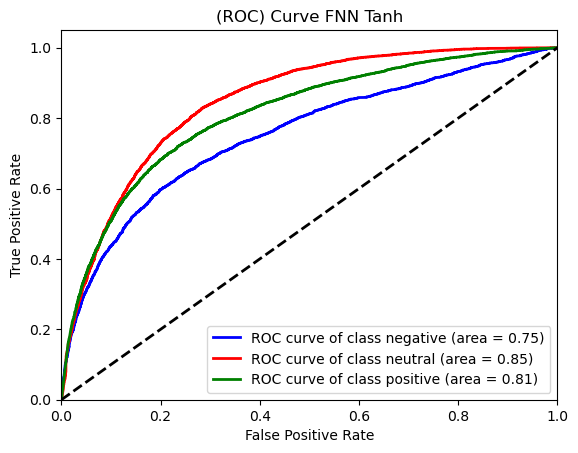

In [10]:
# Binarize the labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score_bin = np.array(all_probs)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve FNN Tanh')
plt.legend(loc="lower right")
plt.show()

As compared to more advanced model, the ROC curve is not that good. However it is able to distingush between classes.